# Ellipses to approximate MODIS iFOVs

From [C3](https://github.com/NiklasPhabian/dissertation/blob/main/mds/C3_Spires.md#ifov-approximation-labelsec_ifov):


We use the fact that we have some idea of the distortion introduced by the sensor's nadir scan angle. From the MODIS Level 1A Earth Location ATBD [@MashNishihamaRobertWolfe1997], we know that the resolution of a \SI{1}{\kilo\meter} spatial element at a \SI{55}{\degree} scan angle has ground dimensions of approximately \SI{4800}{\meter} along-scan and \SI{2000}{\meter} along-track. [@Dozier2008] provides an analytic approach for the relation between sensor zenith and along-scan and along-track (+IFOV) pixel expansions. For simplicity of our purposes, we instead fit an exponential function to data provide by [@MashNishihamaRobertWolfe1997] to establish a relation between nadir scan angle and along-scan and along-track (+IFOV) length (c.f. figure \ref{ifov_growth}.). 

$$ length = \frac{e^{a*x}}{b} + c$$

With:

|             | a   | b    |c     |
|:--          |:--- |:---  |:---  | 
| along-scan  |0.09 | \SI{40.9}{\per\kilo\meter} | \SI{1.00}{\kilo\meter} |
| along-track |0.07 | \SI{35.2}{\per\kilo\meter} | \SI{0.98}{\kilo\meter} |

Using the derived along-track and the along-scan lengths, we create ellipses around each IFOV geolocation, using the along-track length as the length of the semi-minor axis and the along-scan length as the length semi-major axis. We finally orient each ellipse according to the sensor's instantaneous azimuth angle.

In [1]:
%matplotlib widget
import starepandas
import pystare
import matplotlib.pyplot as plt
import geopandas
import copy
import numpy
import pandas

In [2]:
mod03_name = '../tests/data/granules/MOD03.A2017345.1925.006.2017346004924.hdf'
mod03 = starepandas.read_granule(mod03_name, sidecar_path='../tests/data/granules/MOD03.A2017345.1925.006.2017347015352_stare.nc', sidecar=True, xy=True)

In [3]:
mod03_center = copy.copy(mod03[630:634])
mod03 = copy.copy(mod03[0:4])

In [4]:
lat, lon = pystare.to_latlon(mod03.sids)
lon = lon - 360
geoms = geopandas.points_from_xy(x=lon,y=lat, crs=4326)
mod03.set_geometry(geoms, inplace=True)

In [5]:
lat, lon = pystare.to_latlon(mod03_center.sids)
lon = lon - 360
geoms = geopandas.points_from_xy(x=lon,y=lat, crs=4326)
mod03_center.set_geometry(geoms, inplace=True)

## Make ellipses

In [6]:
ellipse_sids = starepandas.io.granules.modis.make_ellipse_sids(mod03, n_partitions=1, num_workers=1, level=17, crs=3857, modis_resolution=1000)
mod03['ellipse_sids'] = ellipse_sids

ellipse_trixels = mod03.make_trixels(sid_column='ellipse_sids', n_partitions=1, num_workers=1)
mod03['ellipse_trixels'] = ellipse_trixels

In [7]:
ellipse_sids = starepandas.io.granules.modis.make_ellipse_sids(mod03_center, n_partitions=1, num_workers=1, level=17, crs=3857, modis_resolution=1000)
mod03_center['ellipse_sids'] = ellipse_sids

ellipse_trixels = mod03_center.make_trixels(sid_column='ellipse_sids', n_partitions=1, num_workers=1)
mod03_center['ellipse_trixels'] = ellipse_trixels

## Make circles

In [8]:
r_circle = 500
r_earth = 6378137
phi = r_circle /2/3.14/r_earth*360
phi

0.004493854613371522

In [9]:
circle_sids = starepandas.make_circular_sids(mod03, level=17, diameter=phi, n_partitions=1, num_workers=1)
mod03['circle_sids'] = circle_sids

cirlce_trixels = mod03.make_trixels(sid_column='circle_sids', n_partitions=1, num_workers=1)
mod03['circle_trixels'] = cirlce_trixels

In [10]:
circle_sids = starepandas.make_circular_sids(mod03_center, level=17, diameter=phi, n_partitions=1, num_workers=1)
mod03_center['circle_sids'] = circle_sids

cirlce_trixels = mod03_center.make_trixels(sid_column='circle_sids', n_partitions=1, num_workers=1)
mod03_center['circle_trixels'] = cirlce_trixels

## Plot

In [11]:
-140.4 +140.05


-0.3499999999999943

In [12]:
-124.85+124.55

-0.29999999999999716

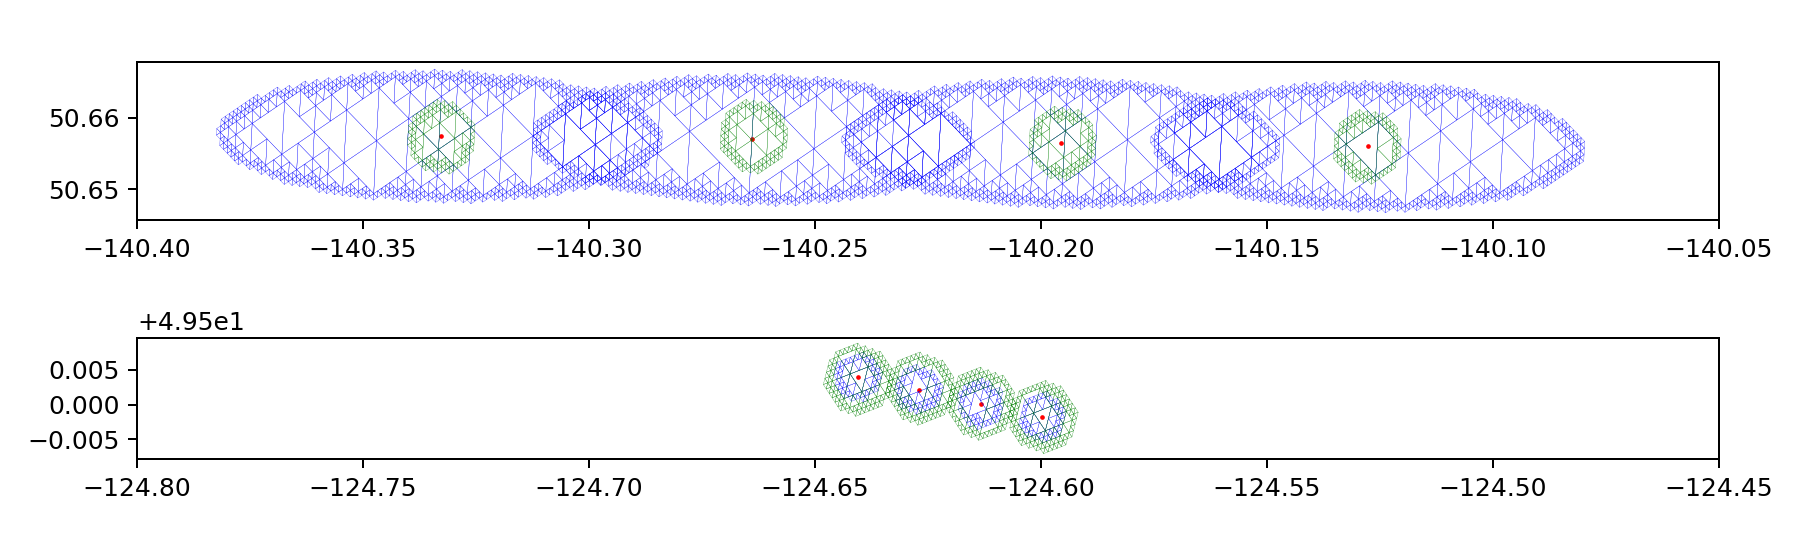

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(10,3), dpi=180)

mod03.set_trixels('ellipse_trixels').plot(ax=ax[0], trixels=True, boundary=True, color='blue', legend=True, linewidth=0.1, zorder=2)
mod03.set_trixels('circle_trixels').plot(ax=ax[0], trixels=True, boundary=True,  linewidth=0.1, zorder=2, color='green')
mod03.plot(ax=ax[0], trixels=False, markersize=3, marker='.', zorder=1, color='red')
ax[0].set_xlim(-140.4, -140.05)

mod03_center.set_trixels('ellipse_trixels').plot(ax=ax[1], trixels=True, boundary=True, color='blue', legend=True, linewidth=0.1, zorder=2)
mod03_center.set_trixels('circle_trixels').plot(ax=ax[1], trixels=True, boundary=True,  linewidth=0.1, zorder=2, color='green')
mod03_center.plot(ax=ax[1], trixels=False, markersize=3, marker='.', zorder=1, color='red')
ax[1].set_xlim(-124.80,-124.45)


fig.tight_layout()

## Fit Ellipse

In [14]:
deg = [0.,10,20,30,40,50,55]
scan_pts = [1, 1.05, 1.2, 1.5, 2, 3.2, 4.83]
trac_pts = [1, 1.028, 1.083, 1.193, 1.367, 1.688, 2.01]

In [15]:
def func(x, a, b, c):
    return numpy.exp(a*x)/b+c

In [16]:
from scipy.optimize import curve_fit
scan_params, cov = curve_fit(func, deg, scan_pts, bounds=(0, [1, 100, 1]))   
trac_params, cov = curve_fit(func, deg, trac_pts, bounds=(0, [1, 100, 1]))   

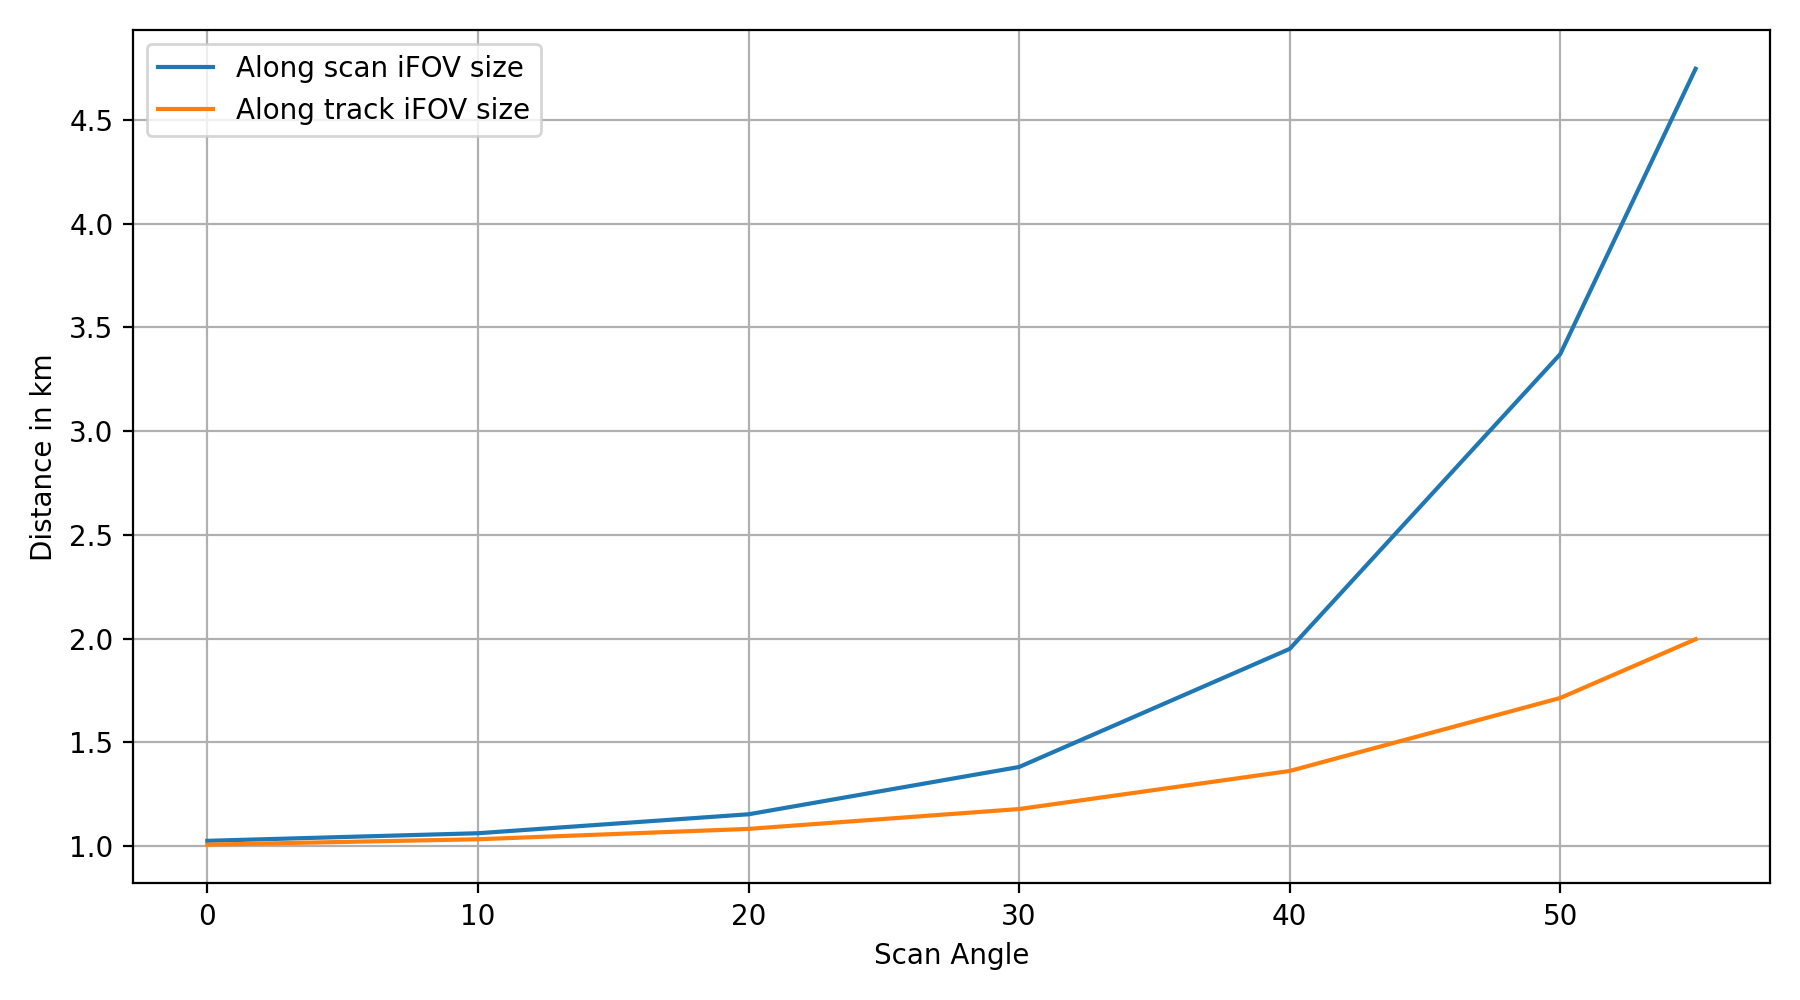

In [17]:
fig, ax = plt.subplots(figsize=(9,5), dpi=200)

df = pandas.DataFrame({'deg': deg, 'scan_pts': scan_pts, 'trac_pts': trac_pts})
df['Along scan iFOV size'] = numpy.exp(scan_params[0]*df['deg'])/scan_params[1]+scan_params[2]
df['Along track iFOV size'] = numpy.exp(trac_params[0]*df['deg'])/trac_params[1]+trac_params[2]

#df.plot(ax=ax, x='deg', y=['scan_pts', 'trac_pts'], grid=True, ylabel='Distance', xlabel='Scan Angle', marker='x', linewidth=0)
df.plot(ax=ax, x='deg', y=['Along scan iFOV size', 'Along track iFOV size'], grid=True, ylabel='Distance in km', xlabel='Scan Angle')
fig.tight_layout()